<a href="https://colab.research.google.com/github/saykim/ds/blob/main/%08cnn_%EC%8B%A4%EC%8A%B54_%EB%AA%A8%EB%8D%B8%EA%B3%A0%EB%8F%84%ED%99%94_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
# from tensorflow.keras import datasets, layers, models
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import datasets, layers, models

170508288/170498071 [==============================] - 13s 0us/step


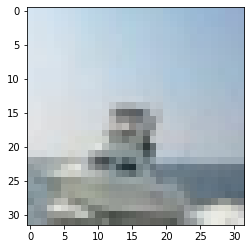

In [2]:
# 데이터 불러오기


(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# 32x32x3 (RGB) 0~255

#Normalizaton
train_images, test_images = train_images/255.0, test_images/255.0

plt.imshow(train_images[100])

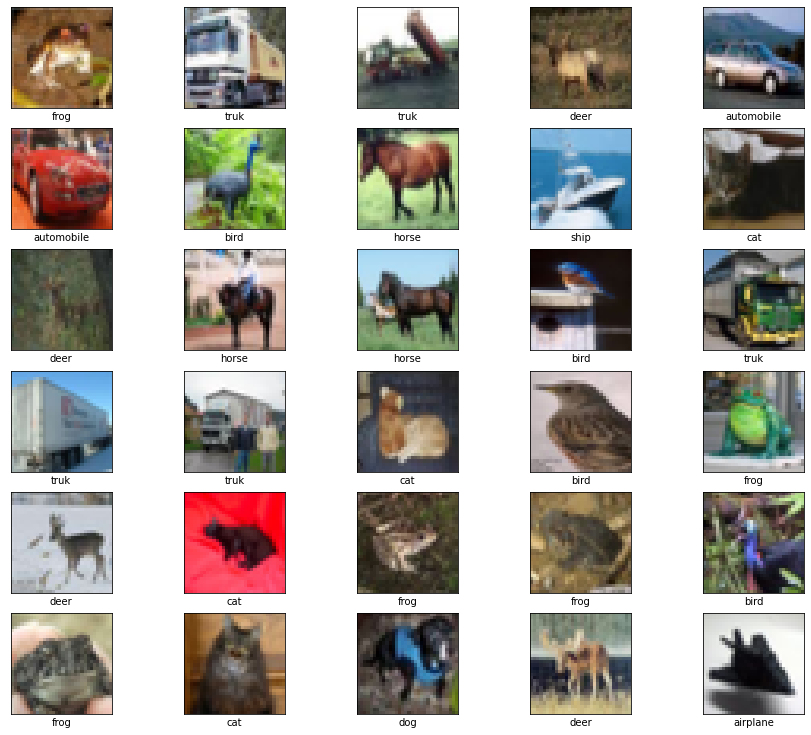

In [3]:
class_names = ['airplane', 'automobile','bird','cat','deer', 'dog','frog','horse','ship','truk']


plt.figure(figsize=(15,13))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]], fontdict={'color':'black'})
plt.show()

## Resnet18

* Network가 깊어질수록, 학습이 잘 이뤄지지 않는 문제점을 해결하고자 함
* Network가 깊어짐으로서 발생하는 손실을 원래 정보를 더해줌으로서 해결

In [4]:
#반복되는 로직이기 때문에 '함수'로 정의

def add_residual_block(inputs, block_number, in_channels, out_channels):
    _ = str(block_number)
    skip = tf.identity(inputs) 
    
    #하나의 residual block를 통과 할 때마다, dimension을 절반으로 줄이고, 채널을 두배로 증가
    # 스트라이드를 통해서 Feature map을 downsampling 합니다. 

    down = 1
    if in_channels != out_channels:
        skip = tf.keras.layers.Conv2D(filters = out_channels,
                                      kernel_size = 1,
                                      strides = (2,2),
                                      padding = 'same')(skip)

        down = 2
    x = tf.keras.layers.Conv2D(filters=out_channels,
                               kernel_size = 3, 
                               padding = 'same', 
                               strides = down)(inputs)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)

    x = tf.keras.layers.Conv2D(filters=out_channels,
                               kernel_size = 3, 
                               padding = 'same')(x)         
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, skip])
    x = tf.nn.relu(x)

    return x






In [20]:
inputs = tf.keras.Input(shape=(32,32,3))
data = tf.keras.layers.Conv2D(filters = 64,
                              kernel_size = 7,
                              strides = 2,
                              padding='same')(inputs)
data = tf.keras.layers.BatchNormalization()(data)
data = tf.keras.layers.Activation('relu')(data)
data = tf.keras.layers.MaxPool2D(pool_size=(3,3),
                                strides = 2,
                                padding='same')(data)
data = add_residual_block(inputs=data, block_number='2_1', in_channels=64, out_channels=64)
data = add_residual_block(inputs=data, block_number='2_2', in_channels=64, out_channels=64)

data = add_residual_block(data, '3_1', 64, 128)
data = add_residual_block(data, '3_2', 128, 128)

data = add_residual_block(data, '4_1', 128, 256)
data = add_residual_block(data, '4_2', 256, 256)

data = add_residual_block(data, '5_1', 256, 512)
data = add_residual_block(data, '5_2', 512, 512)

data = tf.keras.layers.GlobalAvgPool2D()(data)
data = tf.keras.layers.Dense(512, activation='relu')(data)
data = tf.keras.layers.Dense(10, activation ='softmax')(data)


model = tf.keras.Model(inputs=inputs, outputs=data)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_60 (Conv2D)             (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization_51 (BatchN  (None, 16, 16, 64)  256         ['conv2d_60[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_3 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_51[0]

In [11]:
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [7]:
history = model.fit(train_images, train_labels, epochs=20,validation_data=(test_images, test_labels))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 48s 22ms/step - loss: 1.4604 - accuracy: 0.4785 - val_loss: 1.7115 - val_accuracy: 0.4415
Epoch 2/20
1563/1563 [==============================] - 34s 22ms/step - loss: 1.0853 - accuracy: 0.6187 - val_loss: 0.9809 - val_accuracy: 0.6586
Epoch 3/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9004 - accuracy: 0.6882 - val_loss: 1.1439 - val_accuracy: 0.6085
Epoch 4/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.7760 - accuracy: 0.7312 - val_loss: 0.8661 - val_accuracy: 0.6955
Epoch 5/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.6701 - accuracy: 0.7669 - val_loss: 0.8410 - val_accuracy: 0.7238
Epoch 6/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.5764 - accuracy: 0.8022 - val_loss: 0.9779 - val_accuracy: 0.6776
Epoch 7/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.4876 - accuracy: 0.8317 - val_loss: 1.1087 - val_accura

313/313 - 2s - loss: 1.3121 - accuracy: 0.7449 - 2s/epoch - 7ms/step


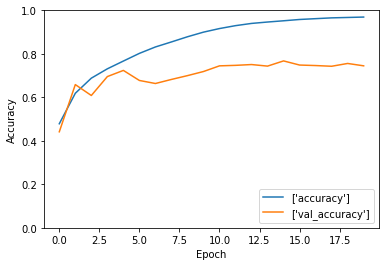

In [ ]:
plt.plot(history.history['accuracy'], label=['accuracy'])
plt.plot(history.history['val_accuracy'], label=['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')



# test_loss, test_acc, test_mse =model_by_func.evaluate(test_images, test_labels, verbose=2)

test_loss, test_acc =model.evaluate(test_images, test_labels, verbose=2)

### callbacks, learning_rate

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [22]:
#callback, batch_size
history = model.fit(train_images, train_labels, epochs=30, batch_size=120, callbacks=[tf.keras.callbacks.EarlyStopping('val_accuracy', patience=5)],validation_data=(test_images, test_labels))

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


417/417 [==============================] - 15s 33ms/step - loss: 1.5462 - accuracy: 0.4461 - val_loss: 2.3290 - val_accuracy: 0.2538
Epoch 2/30
417/417 [==============================] - 13s 30ms/step - loss: 1.1759 - accuracy: 0.5791 - val_loss: 1.3775 - val_accuracy: 0.5200
Epoch 3/30
417/417 [==============================] - 13s 30ms/step - loss: 0.9661 - accuracy: 0.6583 - val_loss: 1.2336 - val_accuracy: 0.5723
Epoch 4/30
417/417 [==============================] - 13s 30ms/step - loss: 0.7953 - accuracy: 0.7209 - val_loss: 1.2186 - val_accuracy: 0.5819
Epoch 5/30
417/417 [==============================] - 13s 30ms/step - loss: 0.6382 - accuracy: 0.7729 - val_loss: 1.2774 - val_accuracy: 0.5905
Epoch 6/30
417/417 [==============================] - 12s 30ms/step - loss: 0.5001 - accuracy: 0.8251 - val_loss: 1.5581 - val_accuracy: 0.5617
Epoch 7/30
417/417 [==============================] - 13s 30ms/step - loss: 0.3668 - accuracy: 0.8721 - val_loss: 1.4281 - val_accuracy: 0.5908
Epo

313/313 - 2s - loss: 1.2809 - accuracy: 0.7228 - 2s/epoch - 7ms/step


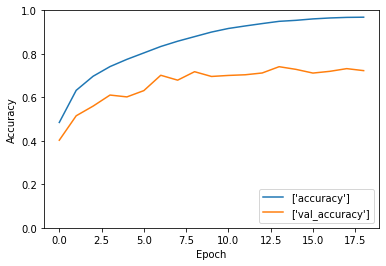

In [13]:
plt.plot(history.history['accuracy'], label=['accuracy'])
plt.plot(history.history['val_accuracy'], label=['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')



# test_loss, test_acc, test_mse =model_by_func.evaluate(test_images, test_labels, verbose=2)

test_loss, test_acc =model.evaluate(test_images, test_labels, verbose=2)